# skorch doctor

Sometimes, when working with neural nets, you'll find that it's quite hard to train them. Often in those cases, it's not that easy to say what's wrong. Do we have bad data? A bad architecture? Or did we just choose bad hyper-parameters?

It's hard to rule out the latter, because there are so many choices. When we have a small problem, we can probably run a grid search or something similar to find the best hyper-parameters, but what if that would be too expensive? Wouldn't it be better if we could inspect the net more closely and find if we are, for instance, dealing with vanishing or exploding gradients?

Thankfully, PyTorch provides facilities like hooks to enable this. But using them correctly can be quite cumbersome. This is where `SkorchDoctor` comes into play. This class allows us to wrap the skorch net and automatically collect important data about our training process that allows us to debug what can be improved.

Many of the tips used here are taken from Andrej Karpathy's excellent content:

- https://karpathy.github.io/2019/04/25/recipe/
- https://www.youtube.com/watch?v=P6sfmUTpUmc


This blog post has also been very helpful when it comes to understanding possible problems in training transformer models specifically:

- https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/

To run this notebook, you need skorch version `0.12.2` or higher. If not released yet, please install from the master branch on github:

`python -m pip install git+https://github.com/skorch-dev/skorch.git`.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Skorch_Doctor.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Skorch_Doctor.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch>=0.12.2'])
except ImportError:
    pass

# A toy binary classification task

To get started, we use a very simple classification problem and a very simple multi-layer perceptron architecture.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from skorch.helper import SkorchDoctor

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [4]:
plt.style.use('seaborn-v0_8')

## Load data

We load a toy classification task from `sklearn`.

In [5]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)

In [6]:
X.shape, y.shape, y.mean()

((1000, 20), (1000,), 0.5)

### Definition of the `PyTorch` classification `module`

This is just an MLP with two hidden layers.

In [7]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, self.num_units)
        self.nonlin = self.nonlin
        self.dropout = nn.Dropout(self.dropout)
        self.dense1 = nn.Linear(self.num_units, self.num_units)
        self.output = nn.Linear(self.num_units, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [8]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=5,
    lr=0.1,
    batch_size=64,
)

## Use skorch doctor

So far, everything we did was just as you would always proceed when working with PyTorch and skorch. Next step, however, is where `SkorchDoctor` enters the picture. We wrap the `net` inside the `SkorchDoctor` class. This wrapper class takes care of adding a bunch of hooks to the PyTorch module that enable us to collect important data.

In [9]:
doctor = SkorchDoctor(net)

### Train the doctor

The `SkorchDoctor` instance itself can be used like any ordinary estimator, i.e. you can fit it, call `predict` on it etc. For us to study the training process, we need to fit the instance with our training data. However, it is recommended to use only a very small amount of data, like 100 samples, and train for a small number of epochs, like 5 in this example:

In [10]:
doctor.fit(X[:100], y[:100])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6913       0.6000        0.6635  0.0368
      2        0.6642       0.5500        0.6603  0.0045
      3        0.6834       0.6000        0.6589  0.0042
      4        0.6783       0.7000        0.6556  0.0061
      5        0.6499       0.6500        0.6588  0.0047


In fact, since we collect so much additional data during training, we might actually run into memory problems if we train too many epochs with too much data. `SkorchDoctor` tries its best to pull that data from GPU memory to main memory as quickly as possible, but you should still monitor memory usage closely if you work with big nets and a large amount of data.

Tip: If you want to save memory and you know that you're only interested in recording specific layers/parameters, you can filter for those by using the `match_fn` argument. As an example, if you want to record only activations/gradients/updates from the layer `"dense0"`, and if you're not interested in the bias, you could pass:

    doctor = SkorchDoctor(net, match_fn=lambda name: ("dense0" in name) and ("bias" not in name))

## Inspect data

Now that we have trained the `SkorchDoctor`, let's take a look at some of the data we collected.

### names of modules, layers, and parameters

For convenience, a few attributes are provided to discover all the modules, layers, and parameter names of the net. Note that by default, skorch sets the `module` and the `criterion` attribute.

In [11]:
doctor.module_names_

['module', 'criterion']

In [12]:
doctor.get_layer_names()

{'module': ['dense0', 'dropout', 'dense1', 'output'], 'criterion': []}

In [13]:
doctor.get_param_names()

{'module': ['dense0.weight',
  'dense0.bias',
  'dense1.weight',
  'dense1.bias',
  'output.weight',
  'output.bias'],
 'criterion': []}

In our case, the criterion is just an `NLLLoss`, which is why it doesn't have any parameters.

### Records

For each training step, the **activations**, **gradients**, and **parameter updates** of each module are recorded. The dictionary thus has the following structure:

    {
        module_name:
            [for each batch and epoch
                {layer_name/param_name: value}
            ]
    }
    
The names of the attributes are:

1. `doctor.activation_recs_`: the activations of each layer for each module
2. `doctor.gradient_recs_`: the gradients of each parameter for each module
3. `doctor.param_update_recs_`: the standard deviation of updates relative to the standard deviation of the parameter for each module

Note that for the parameter updates, we just store one scalar for each parameter tensor and not each individual update. That is, for a weight matrix of shape 100x100, we just store 1 value and not 10,000. Even though we throw away a lot of information this way, we are less likely to run into memory issues this way.

Below, some examples are shown of what we can do with the collected data.

#### Example: plot activations of `dense0` and the gradients of its weights

In [14]:
module = 'module'
layer_name = 'dense0'
param_name = 'dense0.weight'
step = 0  # first training step
activations = doctor.activation_recs_[module][step][layer_name]
gradients = doctor.gradient_recs_[module][step][param_name]

In [15]:
print(activations.shape)  # shape is (batch size, number of output units)
print(gradients.shape)  # shape is the shape of the weights

(64, 10)
(10, 20)


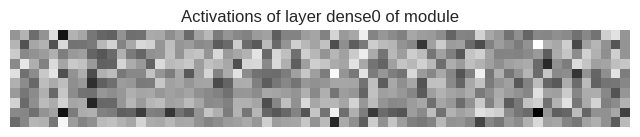

In [16]:
plt.imshow(activations.T)
plt.title(f"Activations of layer {layer_name} of {module}")
plt.xticks([])
plt.yticks([])
plt.grid(None)

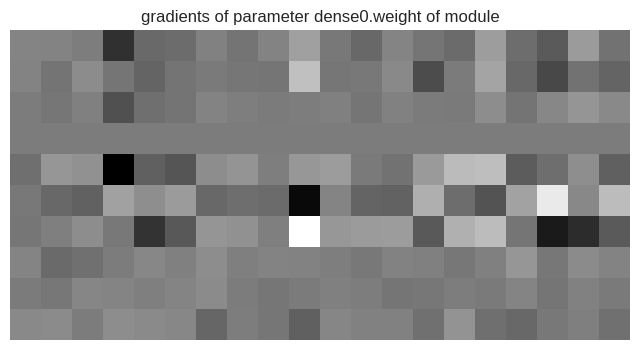

In [17]:
plt.imshow(gradients)
plt.title(f"gradients of parameter {param_name} of {module}")
plt.xticks([])
plt.yticks([])
plt.grid(None)

#### Example: stats of each layer

Get the min, max, and mean absolute activation of each layer from the first training step.

In [18]:
for key, val in doctor.activation_recs_['module'][0].items():
    print(f"activation of layer {key:<9}: min{val.min():>8.4f}, max{val.max():>7.4f}, mean abs{np.abs(val).mean():>7.4f}")

activation of layer dense0   : min -3.9174, max 3.8779, mean abs 0.8519
activation of layer dropout  : min  0.0000, max 7.7558, mean abs 0.4204
activation of layer dense1   : min -2.6741, max 2.8231, mean abs 0.4330
activation of layer output   : min -0.2500, max 1.1730, mean abs 0.1616


#### Example: stats for each parameter

Get the min, max, and mean absolute gradient of each parameter from the last training step.

In [19]:
for key, val in doctor.gradient_recs_['module'][-1].items():
    print(f"activation of layer {key:<14}: min{val.min():>8.4f}, max{val.max():>7.4f}, mean abs{np.abs(val).mean():>7.4f}")

activation of layer output.bias   : min -0.0850, max 0.0850, mean abs 0.0850
activation of layer output.weight : min -0.0882, max 0.0882, mean abs 0.0309
activation of layer dense1.bias   : min -0.0333, max 0.0417, mean abs 0.0157
activation of layer dense1.weight : min -0.0774, max 0.0822, mean abs 0.0117
activation of layer dense0.bias   : min -0.0172, max 0.0332, mean abs 0.0100
activation of layer dense0.weight : min -0.1554, max 0.1079, mean abs 0.0164


## Plots

For convience, `SkorchDoctor` also provides plotting functions for some plots you might commonly want to make.

### Plot train and validation loss

The `plot_loss` method simply plots the training data over time, as well as the validation data (if any). This uses the data stored in `net.history`, so `SkorchDoctor` is not strictly required to make this plot.

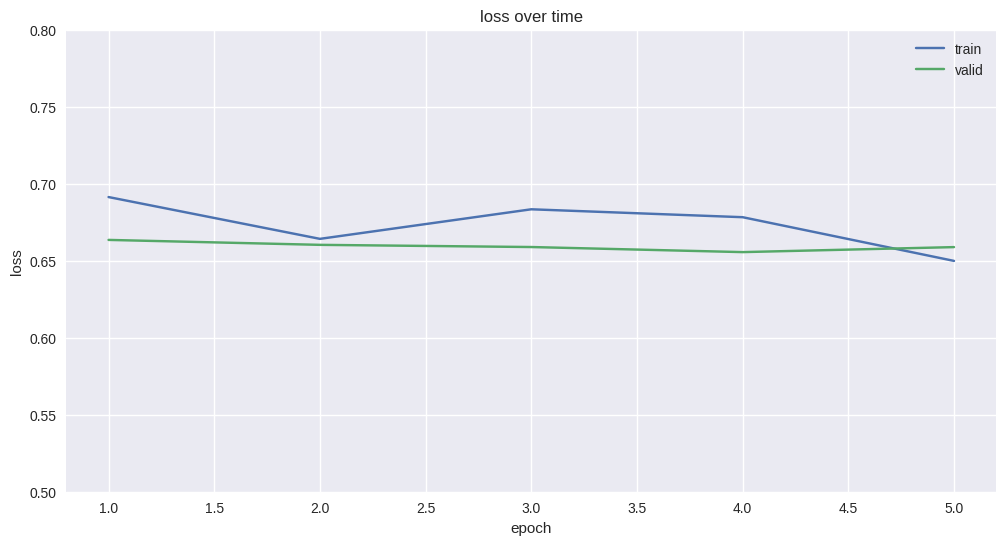

In [20]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax)
ax.set_ylim([0.5, 0.8]);

Tip: Try to overfit a small amount of training data. If your net cannot get a train loss close to 0 when trained for many epochs on a small amount of data, it could indicate that it's capacity is too low for the given task. More layers or more units can help in that case.

Note: All the `plot_*` methods take an optional `ax` (1 plot) or `axes` (≥ 1 plot) argument. That way, you can better control the properties of the resulting matplotlib figure. The axes are also returned by the methods, so that more modifications can be applied after calling the method.

### Plot distribution of activations of each layer

Studying the activations can be especially useful when working with custom architectures. Here we want to look out for extreme outliers. If we encounter any, some remedies could be using better weight initialization, better non-linearities, or some form of normalization (layer norm, batch norm).

#### first step

When creating the plots, we can choose which "step" we want to plot. "step" here means each batch of each epoch, so if we train for 5 epochs with 2 batches each (only training data, not validation), that's a total of 10 steps. To find out the number of training steps, use the `num_steps_` attribute:

In [21]:
doctor.num_steps_

10

To choose which step to plot, pass the `step` argument to the plotting method.

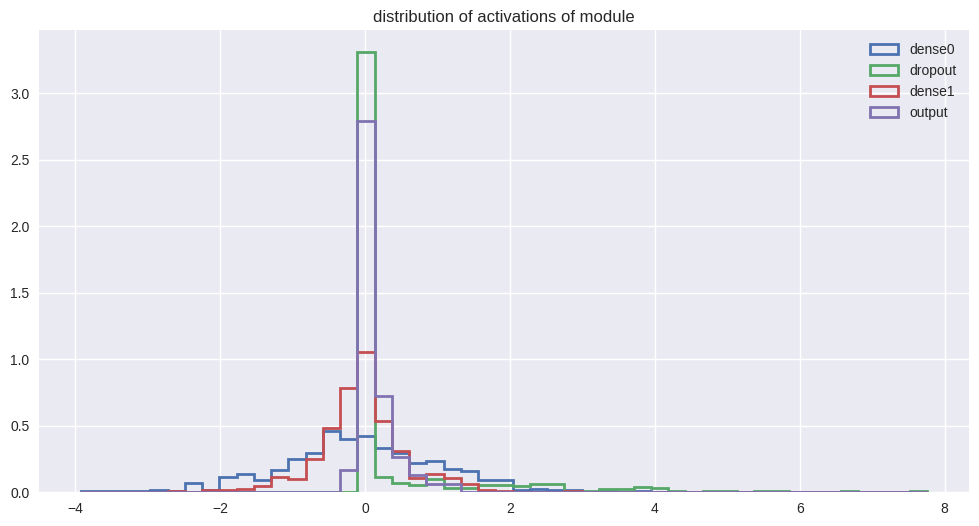

In [22]:
doctor.plot_activations(step=0);

#### last step (default)

The last step can be chosen by passing `step=-1`, but it's not necessary, since -1 is the default.

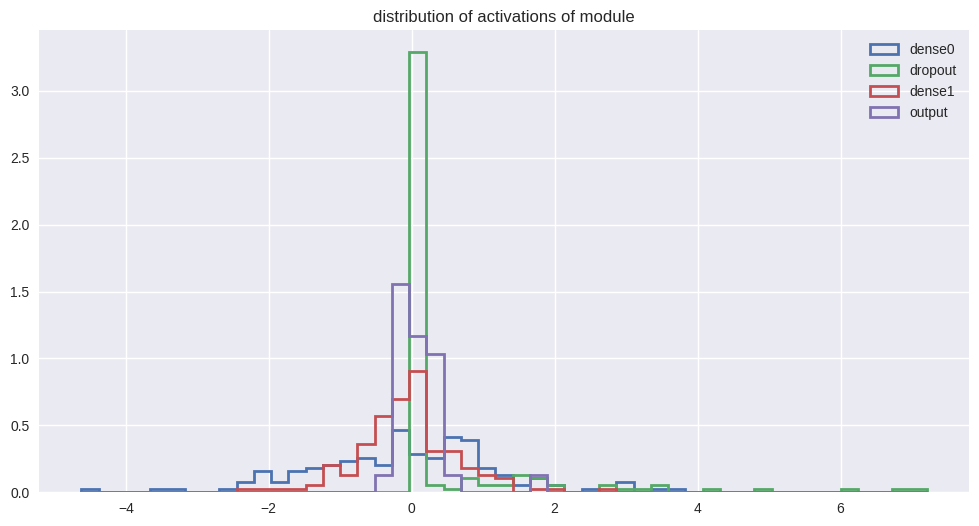

In [23]:
_, axes = plt.subplots(figsize=(12, 6), squeeze=False)
doctor.plot_activations(axes=axes);

### Show gradients of each parameter

#### first step

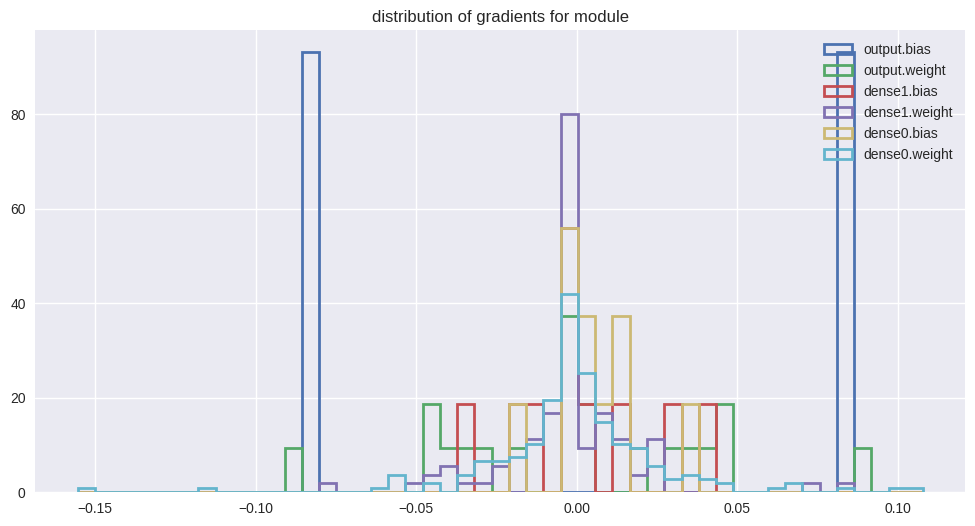

In [24]:
doctor.plot_gradients(step=0);

#### last step (default)

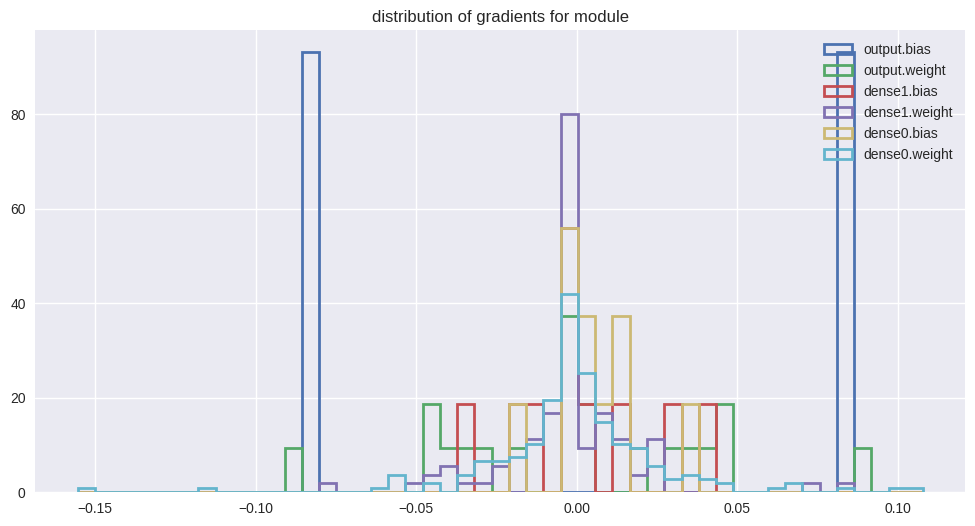

In [25]:
_, axes = plt.subplots(figsize=(12, 6), squeeze=False)
doctor.plot_gradients(axes=axes, step=-1);

Again, we don't see anything too out of the ordinary here. The only "strange" thing could be the two peaks created by `output.bias`. But this is explained by us dealing with a binary classification problem, so this bias only has 2 values.

If we find that some of the gradients are too big, we could consider using the [`GradientNormClipping`](https://skorch.readthedocs.io/en/stable/callbacks.html#skorch.callbacks.GradientNormClipping) callback.

### Plots over time

Looking at one specific training step can only tell us so much. Thankfully, `SkorchDoctor` records the data for each training step and provides plotting funcions to visualize the data over time.

#### Show parameter updates over time

An important metric to look at is how much the net's parameters (i.e. the weights and biases) are updated over time. This is not the same as looking at the gradients, because the updates directly depend on more factors, like the learning rate. Here, we specifically look at the standard deviation of the parameter updates divided by the standard deviation of the parameters themselves. Intuitively, this tells you how much the parameters have been updated on each step.

For a detailed explanation of this, see https://youtu.be/P6sfmUTpUmc?t=5995.

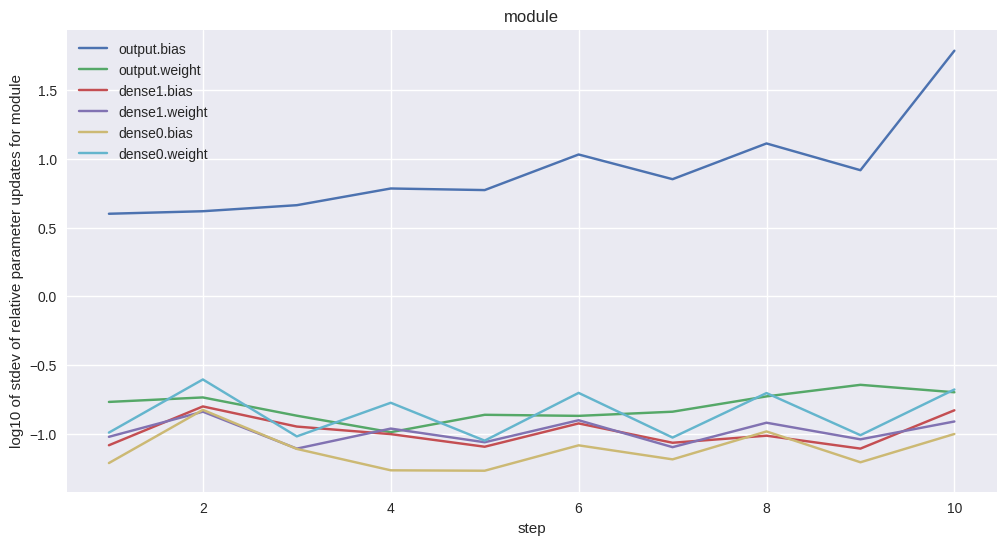

In [26]:
doctor.plot_param_updates();

According to Karpathy, values around 1e-3 (i.e. -3 on the log10 scale of the plot) are good. In this case, our updates have a much higher magnitude. We might thus get better results with a lower learning rate.

We also see that apart from the output bias, all weights are updated more or less equally, which is good. If this were not the case, we could see some improvement by using an adaptive optimizer like `torch.optim.Adam`.

#### activations over time

`SkorchDoctor` also provides methods to plot the distribution of activations and gradients over time. Here we can only ever plot one layer/parameter at a time since the plot would be too crowded otherwise. Just pass the name of the layer/parameter to the method:

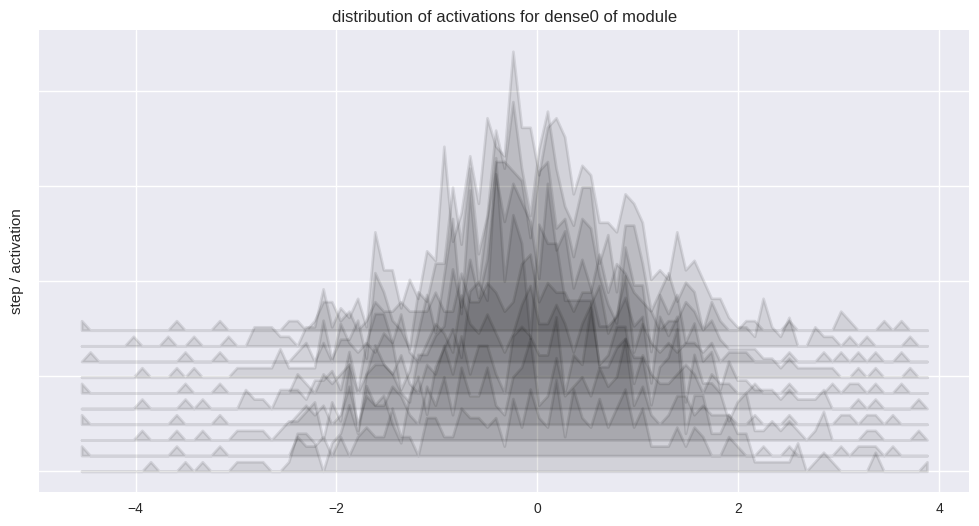

In [27]:
doctor.plot_activations_over_time('dense0');

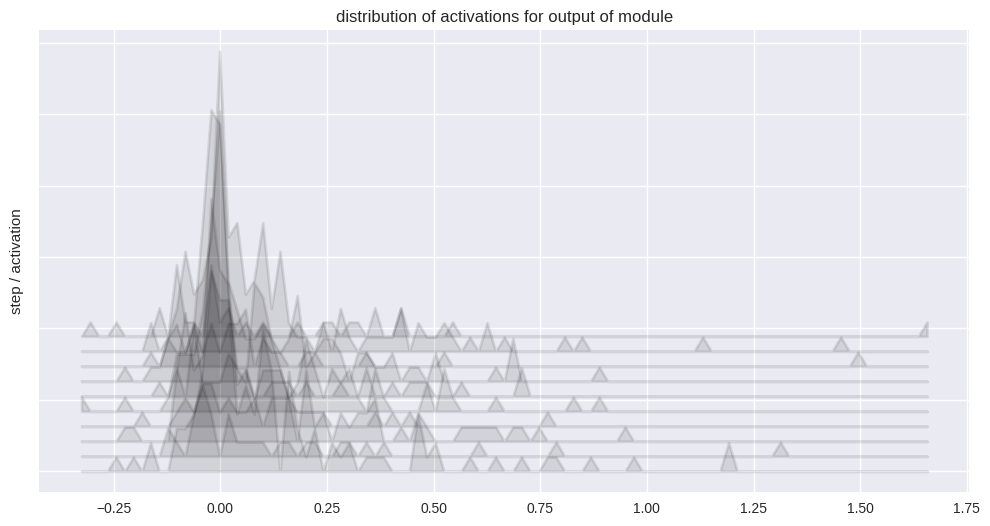

In [28]:
doctor.plot_activations_over_time('output');

#### gradients over time

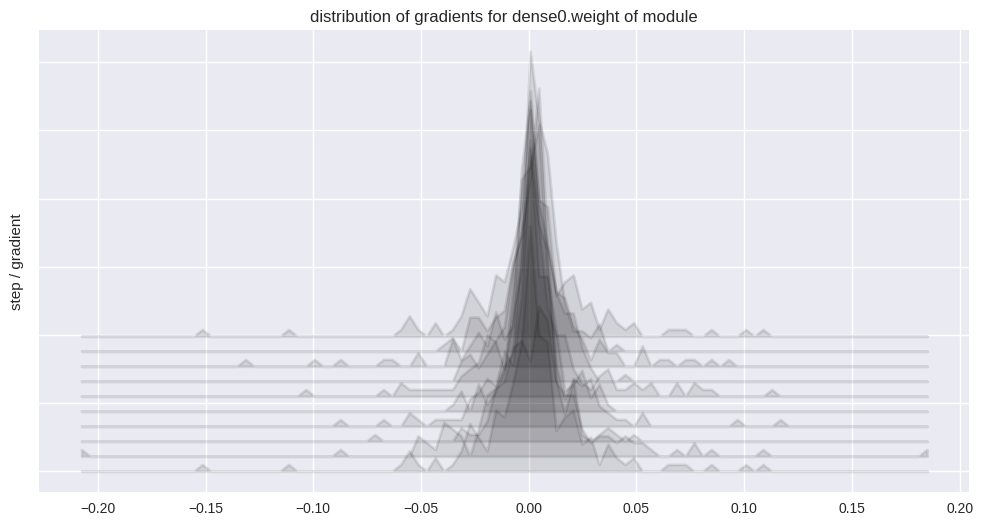

In [29]:
doctor.plot_gradient_over_time("dense0.weight");

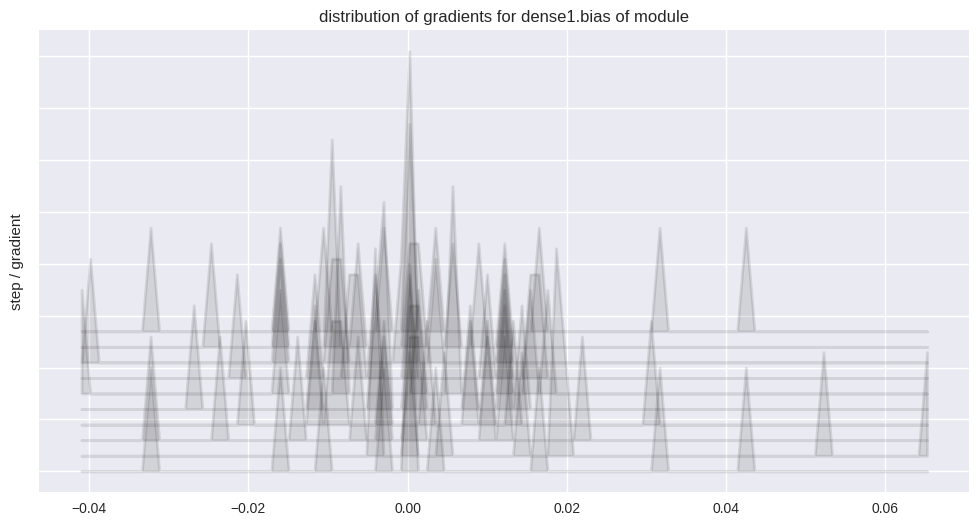

In [30]:
doctor.plot_gradient_over_time("dense1.bias");

# A more realistic example: fine-tuning a BERT model for classification

Now let's take a look at a more realistic example. For this, we will use a BERT model based on the `transformers` library from Hugging Face, and fine-tune it for classification. The example is adopted from [here](https://nbviewer.org/github/skorch-dev/skorch/blob/master/notebooks/Hugging_Face_Finetuning.ipynb), so for an in-depth explanation, please refer to that notebook.

In [31]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'transformers'])
except ImportError:
    pass

## Imports

In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from skorch import NeuralNetClassifier
from skorch.callbacks import ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

In [33]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

## Hyper-parameters

We purposefully choose some bad parameters, namely vanilla SGD as optimizer, and a very high learning rate.

In [34]:
# Choose a tokenizer and BERT model that work together
TOKENIZER = "distilbert-base-uncased"
PRETRAINED_MODEL = "distilbert-base-uncased"

# model hyper-parameters
OPTIMIZER = torch.optim.SGD
LEARNING_RATE = 0.3
MAX_EPOCHS = 3
CRITERION = nn.CrossEntropyLoss
BATCH_SIZE = 8

# device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the data

In [35]:
dataset = fetch_20newsgroups()

In [36]:
X = dataset.data
y = dataset.target

## Specifying the model

In [37]:
class BertModule(nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels

        self.reset_weights()

    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels
        )

    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

In [38]:
net = NeuralNetClassifier(
    BertModule,
    lr=LEARNING_RATE,
    optimizer=OPTIMIZER,
    module__name=PRETRAINED_MODEL,
    module__num_labels=len(set(y)),
    max_epochs=MAX_EPOCHS,
    criterion=CRITERION,
    batch_size=BATCH_SIZE,
    iterator_train__shuffle=True,
    device=DEVICE,
    callbacks=[ProgressBar()],
)

As before, we wrap the net into the `SkorchDoctor` class. This time, however, our model consists of two steps, the tokenizer and the BERT model itself. Therefore, we need to chain the steps together using an sklearn `Pipeline`. But this is no problem, we can put the `SkorchDoctor` instance itself into the pipeline. 

In [39]:
doctor = SkorchDoctor(net)

In [40]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('clf', doctor),
])

In [41]:
pipeline.fit(X[:50], y[:50])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/7 [00:00<?, ?it/s]

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.5725       0.1000        3.0509  3.6938


  0%|          | 0/7 [00:00<?, ?it/s]

      2        3.3660       0.2000        2.9259  3.2012


  0%|          | 0/7 [00:00<?, ?it/s]

      3        3.0143       0.2000        2.7844  3.3375


Pipeline(steps=[('tokenizer',
                 HuggingfacePretrainedTokenizer(tokenizer='distilbert-base-uncased')),
                ('clf',
                 <skorch._doctor.SkorchDoctor object at 0x7f5782827190>)])

## Plots

Now let's look at our collected data to see if there is room for improvement.

### Plot train and validation loss

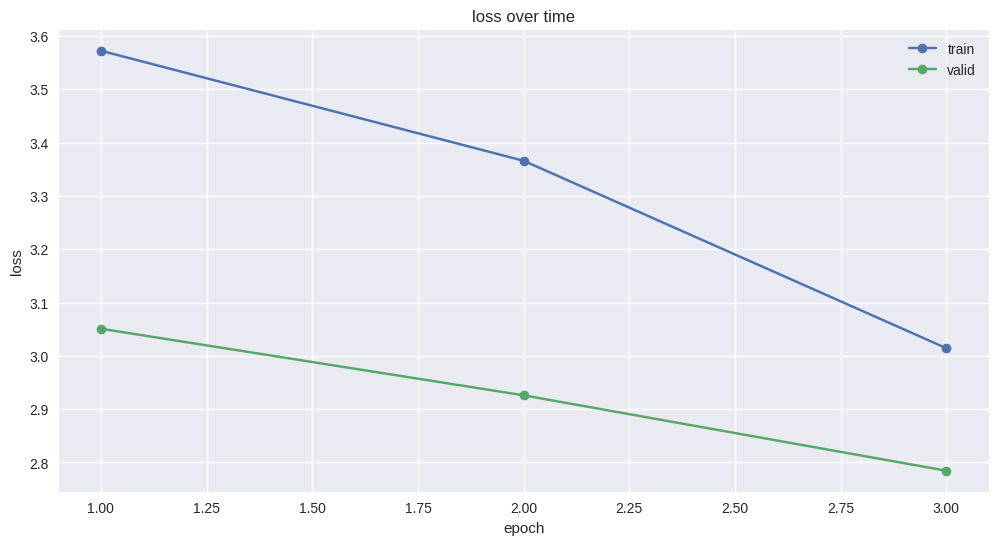

In [42]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax, marker='o');

This looks good so far.

### Plot distribution of activations of each "ffn.lin" layer

Next we could plot the distribution of activations of all layers, but that would be quite useless, because there are too many layers. We can see this by calling `doctor.get_layer_names()`, which lists all layers:

In [43]:
print(f"total number of layers: {len(doctor.get_layer_names()['module'])}")

total number of layers: 95


Here are all the layers by name:

In [44]:
doctor.get_layer_names()

{'module': ['bert.distilbert.embeddings.word_embeddings',
  'bert.distilbert.embeddings.position_embeddings',
  'bert.distilbert.embeddings.LayerNorm',
  'bert.distilbert.embeddings.dropout',
  'bert.distilbert.embeddings',
  'bert.distilbert.transformer.layer.0.attention.q_lin',
  'bert.distilbert.transformer.layer.0.attention.k_lin',
  'bert.distilbert.transformer.layer.0.attention.v_lin',
  'bert.distilbert.transformer.layer.0.attention.dropout',
  'bert.distilbert.transformer.layer.0.attention.out_lin',
  'bert.distilbert.transformer.layer.0.attention[0]',
  'bert.distilbert.transformer.layer.0.sa_layer_norm',
  'bert.distilbert.transformer.layer.0.ffn.lin1',
  'bert.distilbert.transformer.layer.0.ffn.activation',
  'bert.distilbert.transformer.layer.0.ffn.lin2',
  'bert.distilbert.transformer.layer.0.ffn.dropout',
  'bert.distilbert.transformer.layer.0.ffn',
  'bert.distilbert.transformer.layer.0.output_layer_norm',
  'bert.distilbert.transformer.layer.0[0]',
  'bert.distilbert.tr

Note that `SkorchDoctor` disambiguates some of the outputs. E.g. if a layer returns multiple outputs in a list or tuple, a suffix is added to the layer name indicating which element it is, e.g. `bert.distilbert.transformer.layer.0.attention[0]` is the 0th output of that layer.

Similarly, when a dictionary is returned, the dictionary keys are used to disambiguate the outputs, so `bert[logits]` designates the `"logits"` key of the returned dictionary.

So what can we do to study the activations of only specific layers? First of all, we could just access all activations in `doctor.activation_recs_` and do some manual filtering. Instead, we can also use the `match_fn` argument in the plotting methods to filter outputs before plotting them. Pass a function to that argument that returns `True` if an output should be considered and `False` if it should be discarded. This function could be a complex regex or a simple `lambda`, as shown below, where we filter for `ffn.lin1` and `ffn.lin2`:

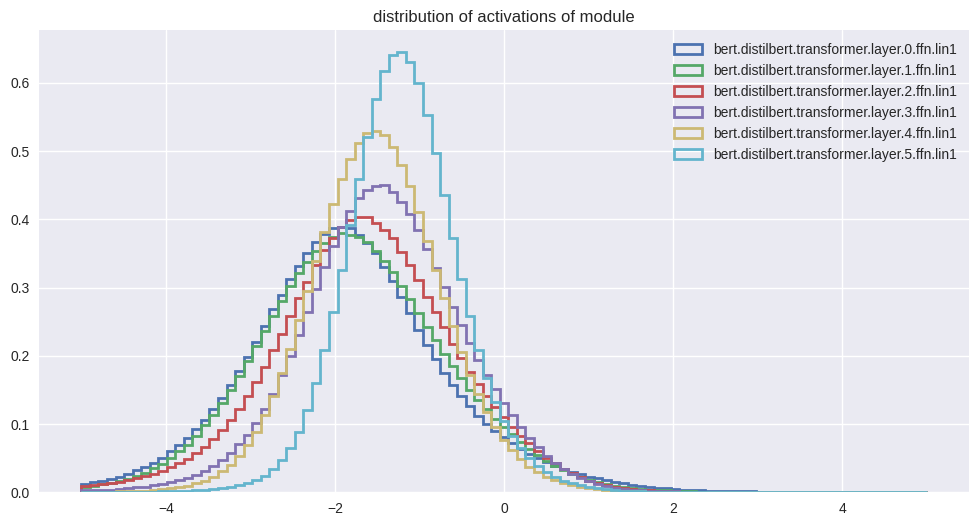

In [45]:
doctor.plot_activations(step=0, match_fn=lambda name: "ffn.lin1" in name, bins=np.linspace(-5, 5, 100));

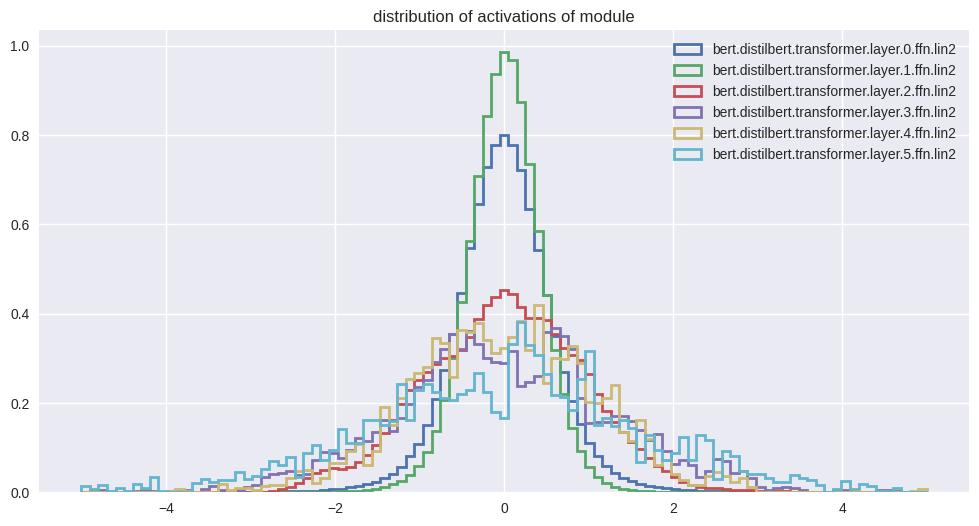

In [46]:
doctor.plot_activations(step=-1, match_fn=lambda name: "ffn.lin2" in name, bins=np.linspace(-5, 5, 100));

These are just some examples, but in general, we should expect the activations to be well behaved. After all, we're using the common BERT architecture and we can assume that it has been designed to create well-behaved activations.

### Show gradients of each parameter

Next let's take a look at gradients. The chance that something went wrong here is higher, since we defined the optimizer and learning rate ourselves, and we might have chosen bad ones.

Again, as before, we don't want to plot the gradients for all parameters, because that would be more than 100!

In [47]:
print(f"total number of parameter tensors: {len(doctor.get_param_names()['module'])}")

total number of parameter tensors: 104


Instead, let's only look at a subset of layers. Here, we choose `"transformer.layer.0"`, i.e. the first transformer block of the BERT model, and only the weights of those layers, not the biases:

#### first step

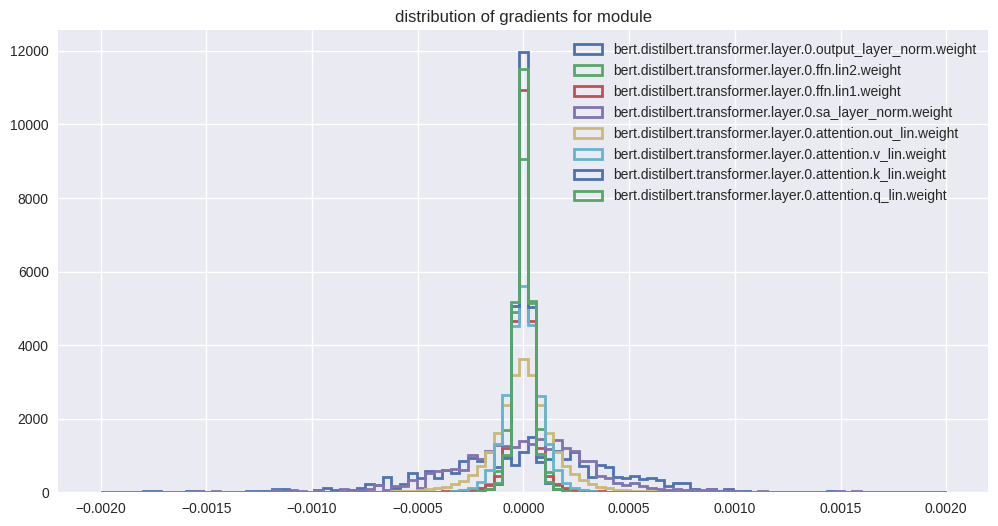

In [48]:
doctor.plot_gradients(
    step=0,
    match_fn=lambda name: "transformer.layer.0" in name and "weight" in name,
    bins=np.linspace(-0.002, 0.002, 100),
);

#### last step

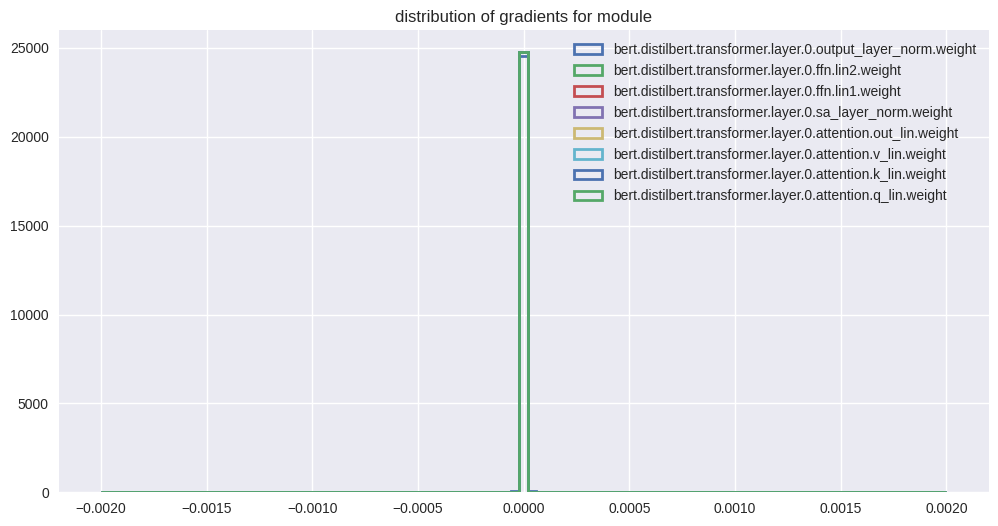

In [49]:
doctor.plot_gradients(
    step=-1,
    match_fn=lambda name: "transformer.layer.0" in name and "weight" in name,
    bins=np.linspace(-0.002, 0.002, 100)
);

We can see that the magnitude of the gradients is quite small in the first step, and in the last step, they're almost 0 (a similar picture would emerge for the other layers). This is not good, our model doesn't learn when the gradients are too small.

### Show parameter updates over time

So to get a better picture of how the parameters behave over time, let's plot the parameter updates for each step of the same parameters.

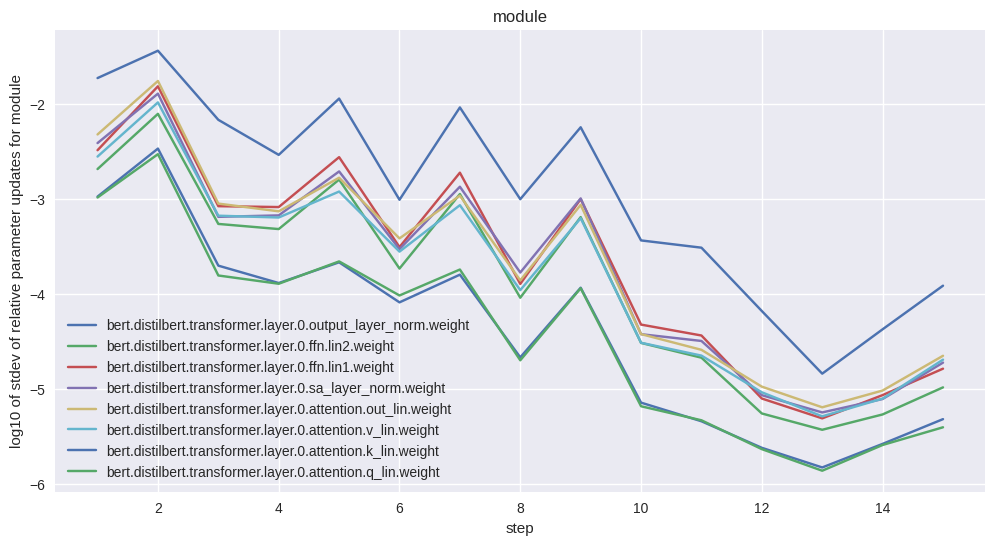

In [50]:
doctor.plot_param_updates(match_fn=lambda name: "transformer.layer.0" in name and "weight" in name);

As we can see, the magnitude of the updates looks good at the start, being in the range of 10e-3 (note the log10 scale). However, we quickly see a decline, going below 10e-5 for some parameters, which is very small.

## How to proceed from here

In general, it is hard to give blanket advice on how to remidy problems in model training. The purpose of `SkorchDoctor` is to help you diagnose the problems, but you have to decide what the right cure is. For this specific problem, what you could try is to use an optimizer with an adaptive learning rate. Try replacing the `torch.optim.SGD` optimizer by `torch.optim.AdamW` (with a lower learning rate, such as `5e-5`) and see if it helps.